In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

C:\Users\andr\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [156]:
@np.vectorize
def real_num(s, prev=None, allow_pow=True):
    if '?' in s or len(s) > 4:
        return float('NaN')
    if len(s) == 4:
        if allow_pow:
            if s[-1] == '1':
                return real_num(s[:-1], allow_pow=False)/10**3
            elif s[-1] == '2':
                return real_num(s[:-1], allow_pow=False)/10**4
            elif s[-1] == '3':
                return real_num(s[:-1], allow_pow=False)/10**5
        if s == '1000':
            return 1000.0
        else:
            return float('NaN')
    
    return float(s)

def second_filter(x, y):
    for i in range(1, len(x) - 1):
        if abs(y[i] - y[i - 1]) > 50 and abs(y[i] - y[i + 1]) > 50 and (y[i] - y[i + 1]) * (y[i] - y[i - 1]) > 0:
            y[i] = float('NaN')
            #print("!")
        #if abs(y[i] - y[i - 1]) != 0.0: print(abs(y[i] - y[i - 1]), abs(y[i] - y[i + 1]), (y[i] - y[i + 1]) * (y[i] - y[i - 1]))
    mask = y == y
    return x[mask], y[mask]

def order_swap(t, y, order):
    curr_order = 0
    keys = list(sorted(order.keys()))
    ind = 0
    for i in range(len(y)):
        if len(keys) > ind + 1 and t[i] > keys[ind + 1]:
            ind += 1
            
        y[i] *= 10**order[keys[ind]]
    return y

def plot_measure(name, order = None, log=True):
    d = pd.read_csv(f"data/{name}.csv", delimiter=";", comment = "#", header=None)
    data = np.array([d[0], d[1]])

    plt.figure(figsize=(10,7))

    def filter_bad(time, p):
        p = real_num(p)

        mask = p == p
        return time[mask], p[mask]
    
    

    x, y = filter_bad(data[0], data[1])
    if order is not None:
        y = order_swap(x, y, order)
    x, y = second_filter(x, y)
    
    y = uniform_filter1d(y, 4)
    if log: plt.yscale('log')
    #plt.loglog()
    plt.plot(x, y)

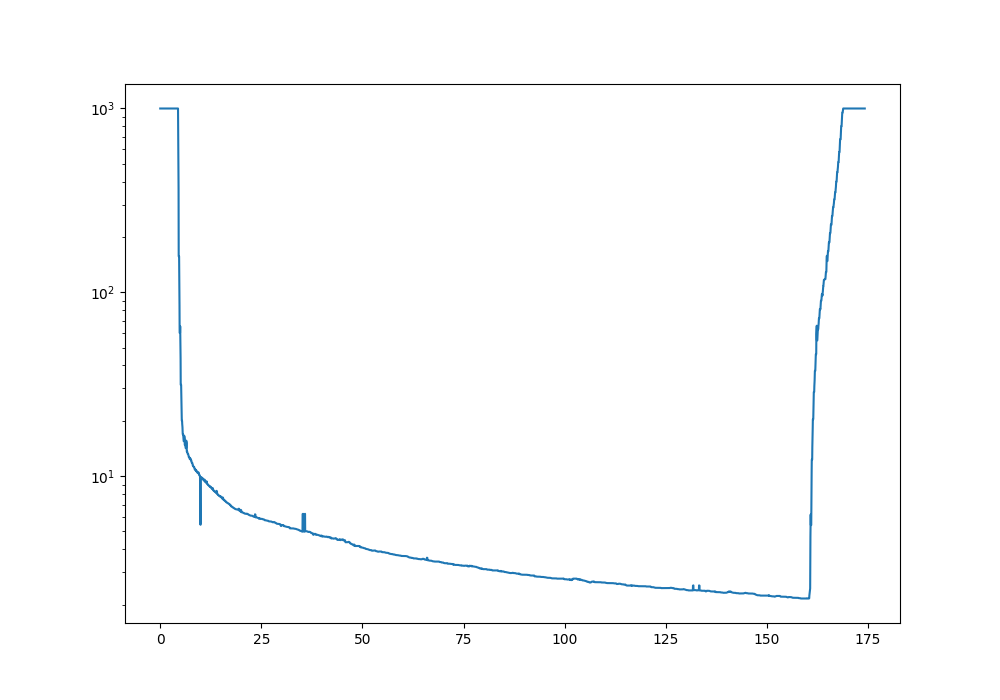

In [196]:
%matplotlib widget
plot_measure('IMG_5566', {0: 0, 4.71: -1, 9.89: -2, 161: -1, 163.8: 0})

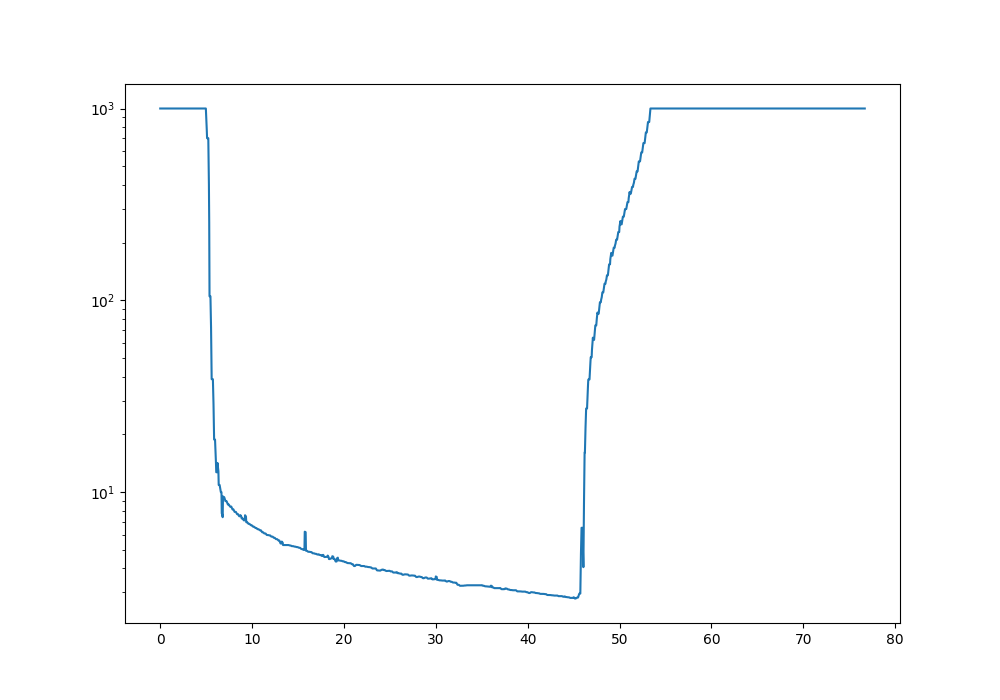

In [197]:
%matplotlib widget
plot_measure('IMG_5567', {0: 0, 5.5: -1, 6.7: -2, 46.1: -1, 48.0: 0})

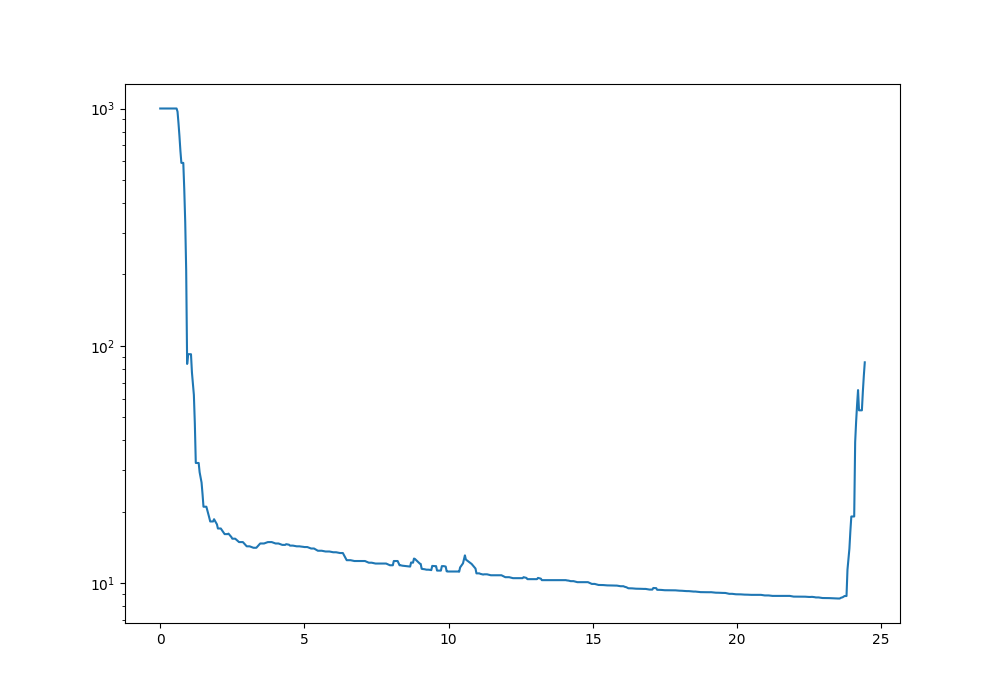

In [198]:
%matplotlib widget
plot_measure('IMG_5568', {0:0, 0.86:-1, 14.87: -2, 23.85: -1})

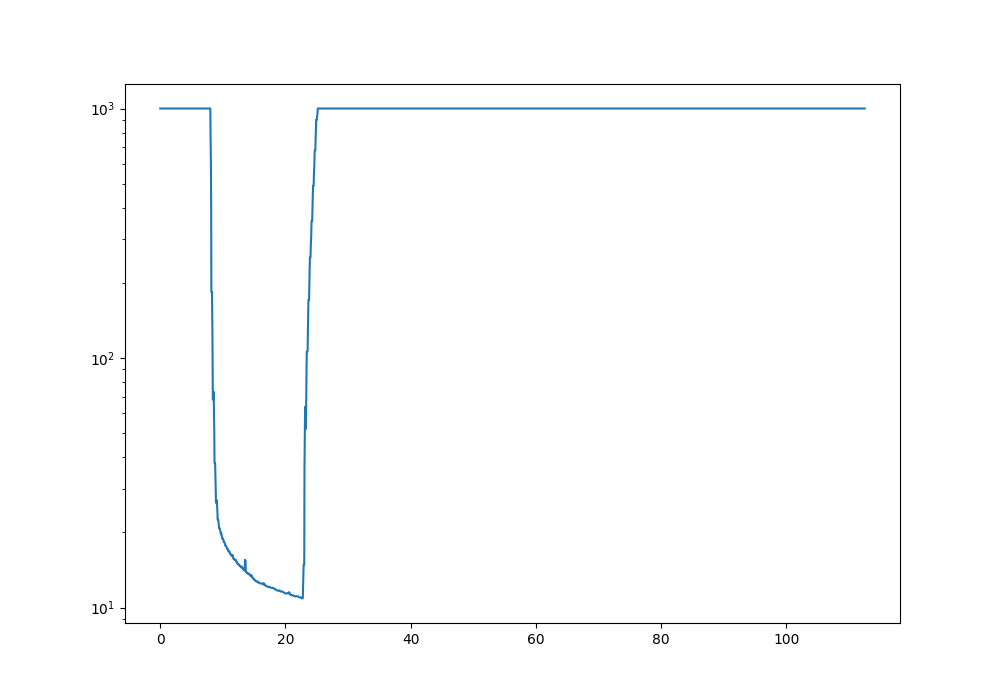

In [199]:
%matplotlib widget
plot_measure('IMG_5569', {0:0, 8.3: -1, 23.3: 0})

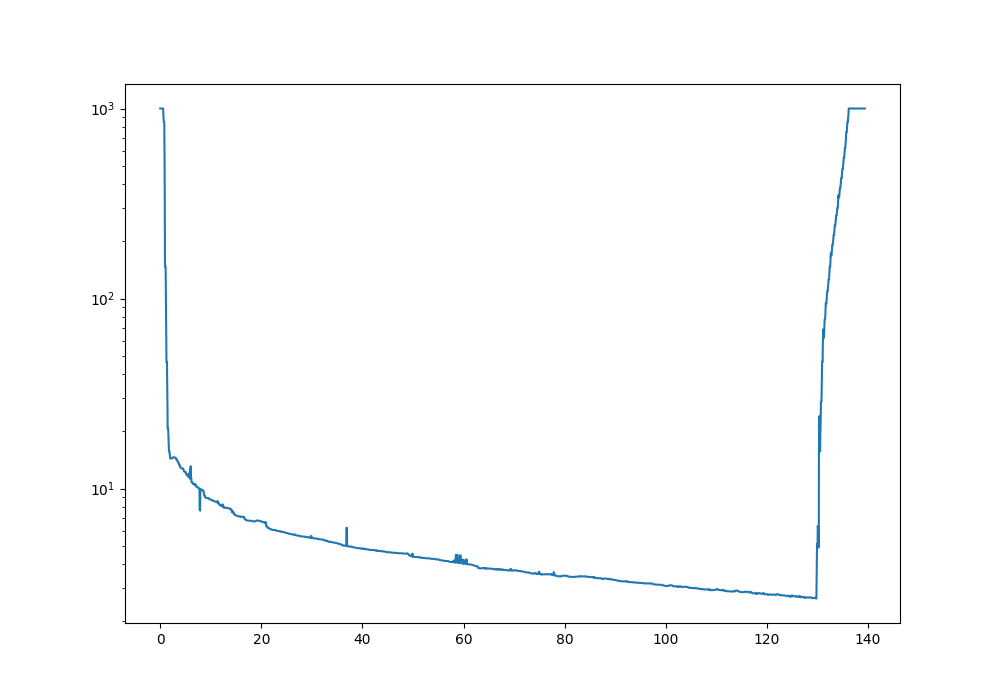

In [195]:
%matplotlib widget
plot_measure('IMG_5570', {0:0, 1.1: -1, 7.81: -2.0, 130.3: -1, 131.8: 0})

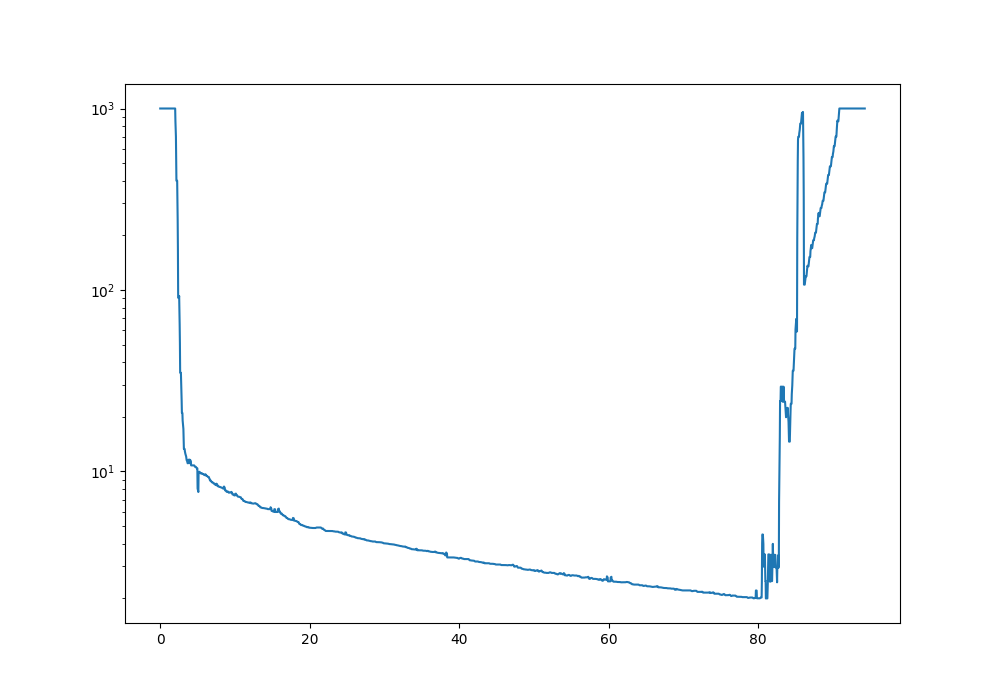

In [200]:
%matplotlib widget
plot_measure('build_2', {0:0, 2.3: -1, 5.0: -2, 82.8: -1, 85.25: 0})

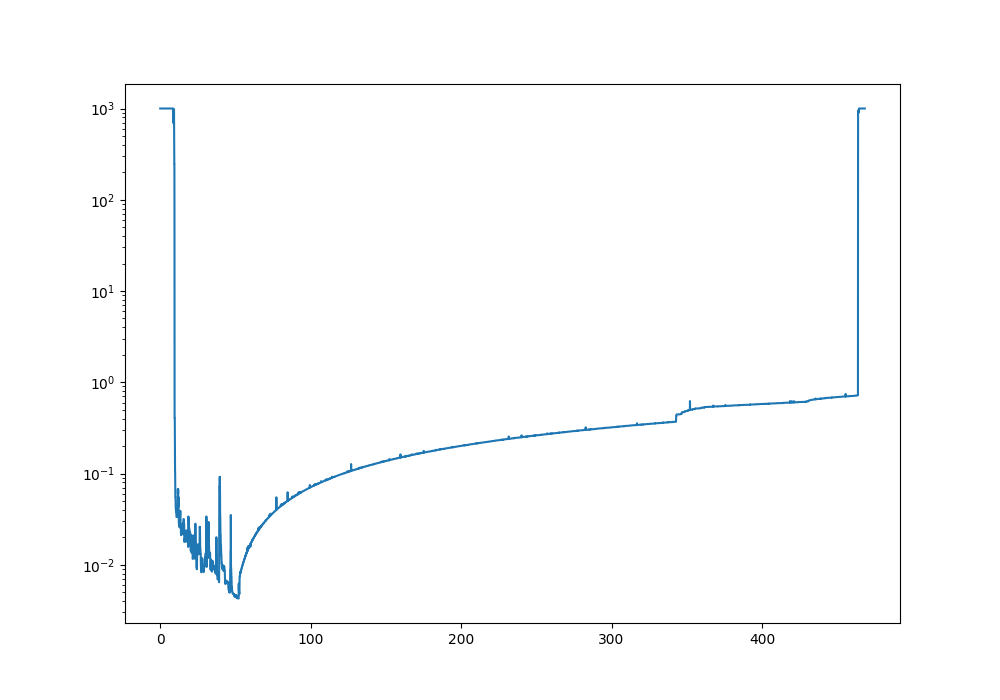

In [201]:
%matplotlib widget
plot_measure('nothing') #, {0:0, 9.4: -4, 10.5: -6, 54.68: -5, 463:0}

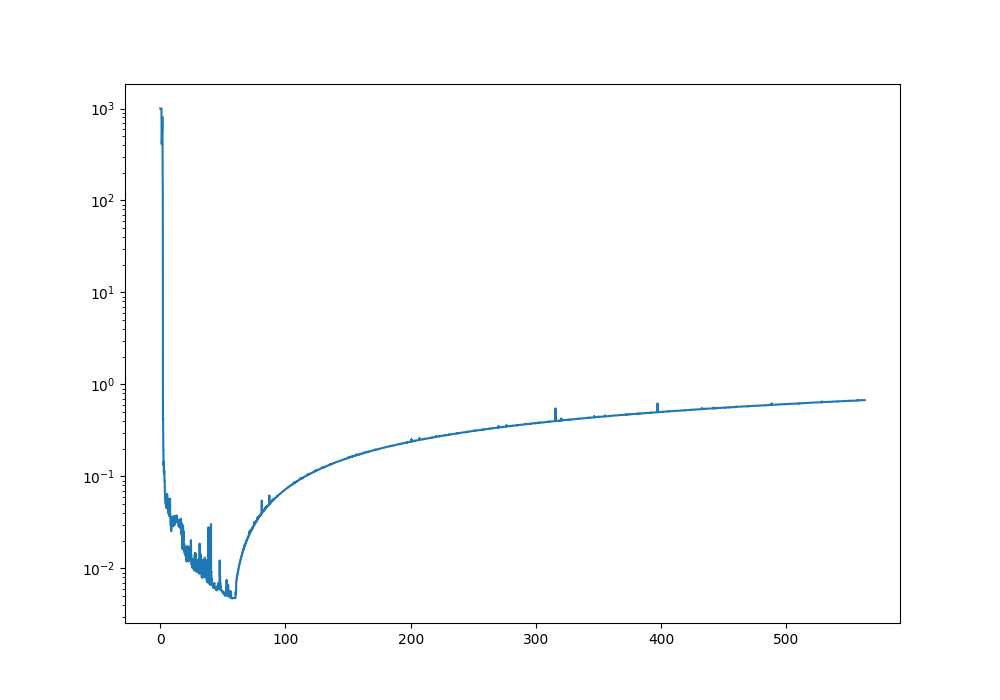

In [202]:
%matplotlib widget
plot_measure('simple')

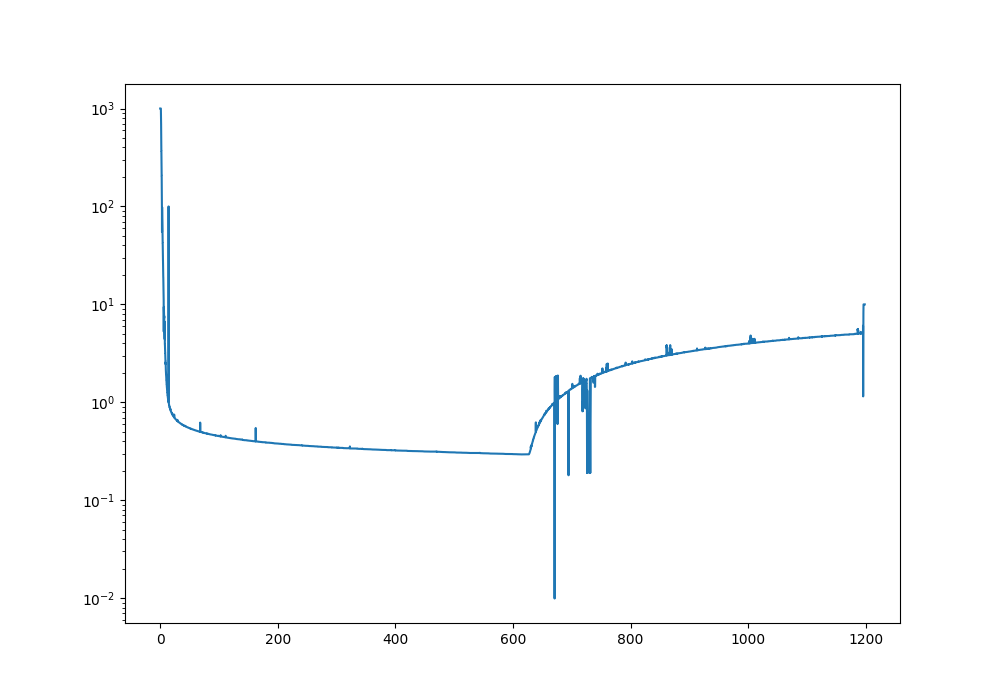

In [203]:
%matplotlib widget
plot_measure('ZERO', {0: 0, 2.9: -1, 5.9: -2, 14.1: 0, 670.691: -2})

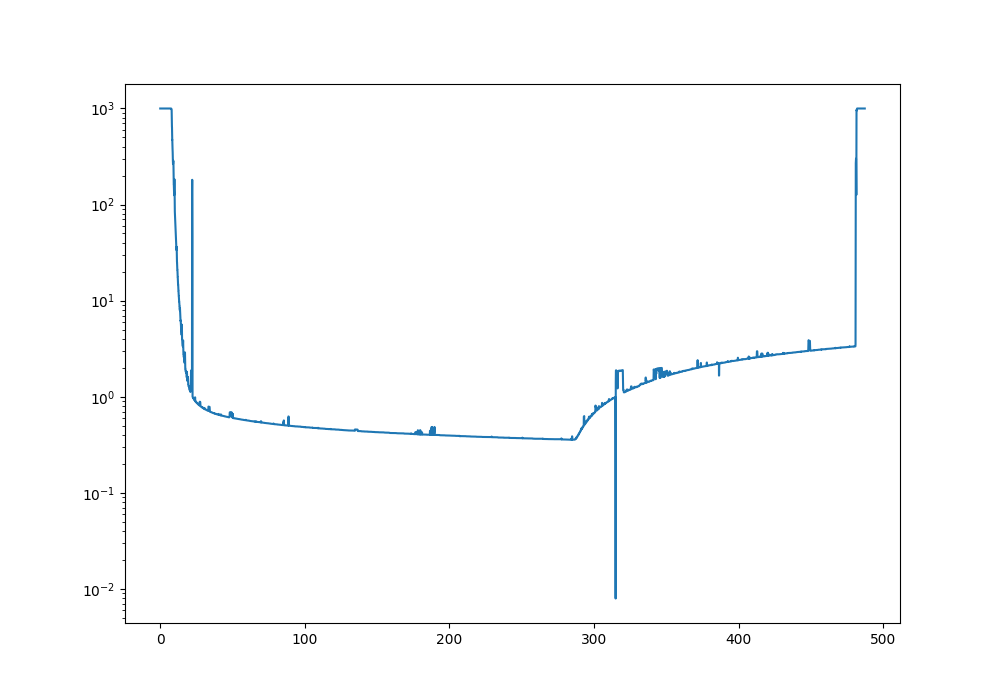

In [204]:
%matplotlib widget
plot_measure('I', {0:0, 9.9: -1, 12.92: -2, 22: 0, 314.8: -2, 481: 0})

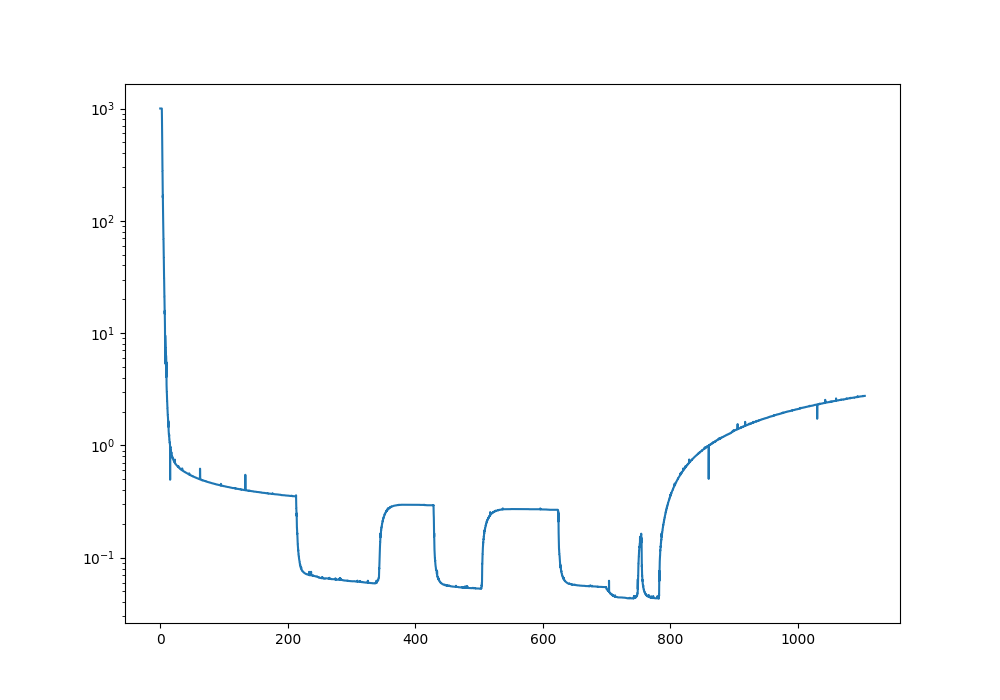

In [205]:
%matplotlib widget
plot_measure('II', {0: 0, 4.63: -1, 7.57: -2, 15.52: 0, 859.9: -2})

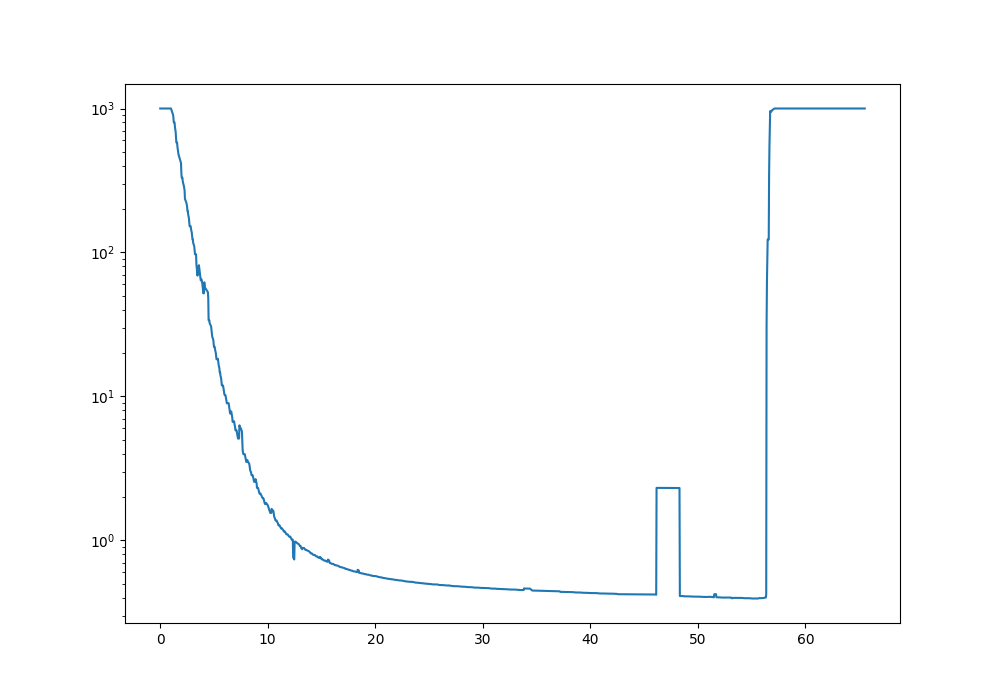

In [251]:
%matplotlib widget
plot_measure('III_1', {0:0, 3.08:-1, 6.1: -2, 12.43: 0})

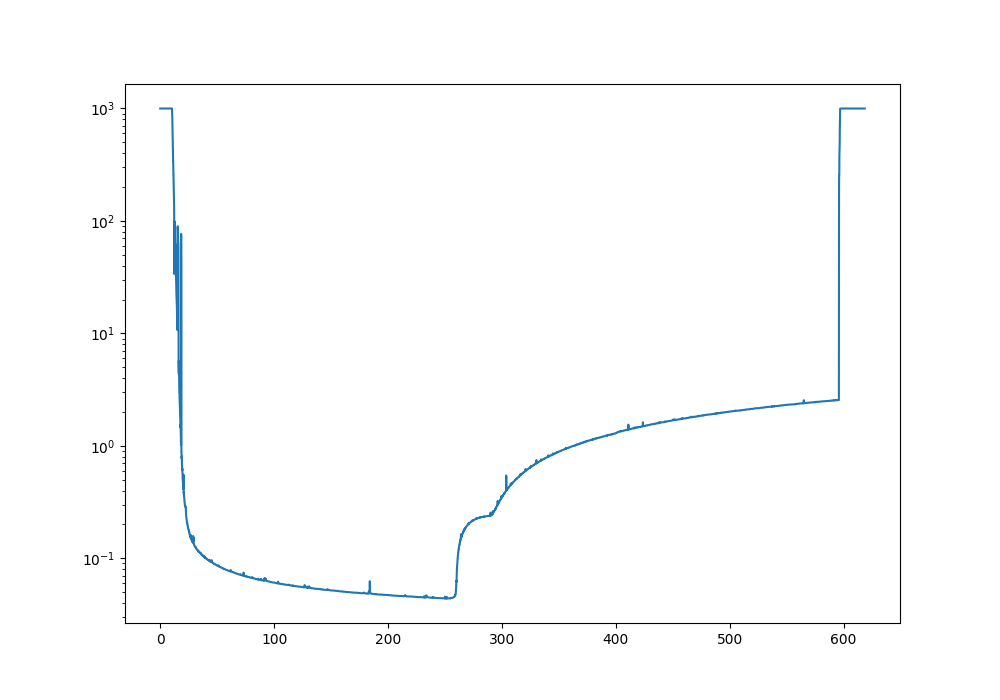

In [250]:
%matplotlib widget
plot_measure('III_2', {0:0, 12.3: -1, 16.0: -2, 18.3: 0, 362.75: -2, 595.9: 0})